In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

df1 = pd.read_csv("bigdata1.csv", sep=";")
df1.shape




(1030, 6)

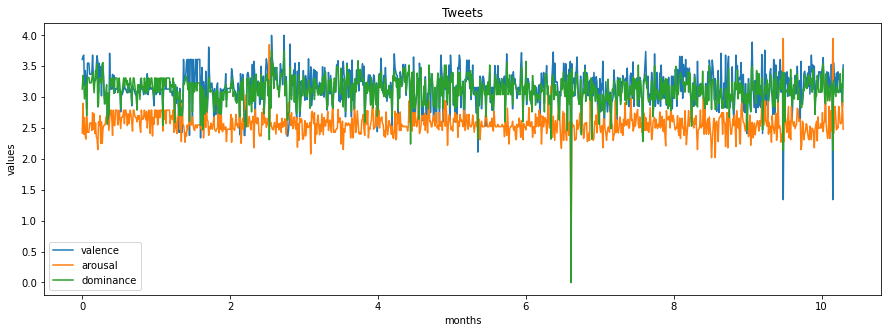

In [7]:
df1_v = df1["Valence"]
df1_a = df1["Arousal"]
df1_d = df1["Dominance"]
x = df1.index/100
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(x, df1_v, label='valence')
plt.plot(x, df1_a, label='arousal')
plt.plot(x, df1_d, label='dominance')
plt.xlabel('months')
plt.ylabel('values')
plt.title("Tweets")
plt.legend()


In [8]:
#Testing for valence 
df1_valence = df1['Valence'].values.astype(float)
df1_valence

df1_valence_test_size = 100
df1_valence_train_data = df1_valence[:-df1_valence_test_size]
df1_valence_test_data = df1_valence[-df1_valence_test_size:]
print(len(df1_valence_train_data), len(df1_valence_test_data))

#Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
df1_valence_train_data_N = scaler.fit_transform(df1_valence_train_data.reshape(-1,1))


930 100


In [9]:
df1_valence_train_data_N = torch.FloatTensor(df1_valence_train_data_N).view(-1)
train_windows = 10

def create_inout_sequences(input_data, train_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-train_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window:i+train_window+1]
        inout_seq.append((train_seq, train_label))
        
    return inout_seq

train_inout_seq = create_inout_sequences(df1_valence_train_data_N, train_windows)
train_inout_seq

[(tensor([0.8050, 0.8300, 0.8400, 0.5950, 0.7150, 0.6450, 0.4050, 0.7750, 0.7750,
          0.7750]),
  tensor([0.6850])),
 (tensor([0.8300, 0.8400, 0.5950, 0.7150, 0.6450, 0.4050, 0.7750, 0.7750, 0.7750,
          0.6850]),
  tensor([0.6850])),
 (tensor([0.8400, 0.5950, 0.7150, 0.6450, 0.4050, 0.7750, 0.7750, 0.7750, 0.6850,
          0.6850]),
  tensor([0.6850])),
 (tensor([0.5950, 0.7150, 0.6450, 0.4050, 0.7750, 0.7750, 0.7750, 0.6850, 0.6850,
          0.6850]),
  tensor([0.7000])),
 (tensor([0.7150, 0.6450, 0.4050, 0.7750, 0.7750, 0.7750, 0.6850, 0.6850, 0.6850,
          0.7000]),
  tensor([0.8400])),
 (tensor([0.6450, 0.4050, 0.7750, 0.7750, 0.7750, 0.6850, 0.6850, 0.6850, 0.7000,
          0.8400]),
  tensor([0.6650])),
 (tensor([0.4050, 0.7750, 0.7750, 0.7750, 0.6850, 0.6850, 0.6850, 0.7000, 0.8400,
          0.6650]),
  tensor([0.6150])),
 (tensor([0.7750, 0.7750, 0.7750, 0.6850, 0.6850, 0.6850, 0.7000, 0.8400, 0.6650,
          0.6150]),
  tensor([0.6350])),
 (tensor([0.7750

In [10]:
#Creating the LSTM
#Hidden layer size = represents amount of neurons in each layer

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [11]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [12]:
#Training

epochs = 200
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1,1,model.hidden_layer_size), torch.zeros(1,1,model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i%25 == 0:
        print(f"epoch: {i:3} | loss: {single_loss.item():10.8f}")
        
print(f"epoch: {i:3} | loss: {single_loss.item():10.8f}")
        
        
        

epoch:   0 | loss: 0.00013275
epoch:  25 | loss: 0.00066301
epoch:  50 | loss: 0.00074099
epoch:  75 | loss: 0.00104254
epoch: 100 | loss: 0.00127273
epoch: 125 | loss: 0.00095474
epoch: 150 | loss: 0.00264767
epoch: 175 | loss: 0.00412880
epoch: 199 | loss: 0.00310242


In [13]:
future_pred = 100
df1_test_inputs = df1_valence_train_data_N[-train_windows:].tolist()

model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(df1_test_inputs[-train_windows:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_layer_size), torch.zeros(1,1,model.hidden_layer_size))
        df1_test_inputs.append(model(seq).item())

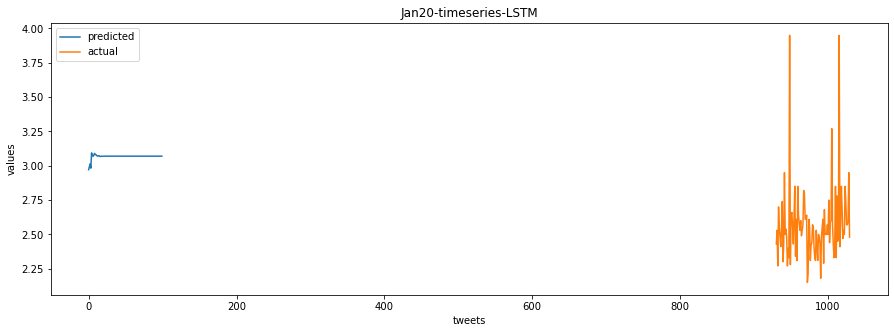

In [29]:
#De-normalization
df1_actual_pred = scaler.inverse_transform(np.array(df1_test_inputs[train_windows:]).reshape(-1,1))
#Plot

plt.plot(df1_actual_pred, label='predicted')
plt.plot(df1_a[-100:], label='actual')
plt.xlabel('tweets')
plt.ylabel('values')
plt.title("-")

plt.legend()

In [30]:
df1_actual_pred
df1_a.iloc[-100:]

100